# ML@SJSU Ribonanza Project
### Active Members / Roles
Haydon Behl / Project Lead
Neal Chandra
Eliot Hall
<div style="text-align: right">If your name isn't here| yet, add it to the Project Members google sheet (or speak to me abt it)  -Haydon&nbsp;&nbsp;&nbsp;</div>

## Todo list
- [x] Finish baseline model
- [ ] Convert data preprocess pipeline
| Current data format: 000100010001...[1 rows, 1644 columns, batchsize 32]
| New data format: 0001,0001,0001...[4 rows, 411 columns, batchsize 32]
| Assigned Members: Neal, Haydon
- [ ] Create 2-label Classification model (Reactive / Non-Reactive)
- [ ] Produce a submission with current model (and design a better way to process test_sequences.csv)
| Assigned Members: Haydon


### Getting Started Instructions
1. Create a new project with your IDE (recommended: pycharm)
2. Keep this .ipynb notebook in the root directory of your project.
3. Download all files from the Kaggle page.
4. Extract to ./input (notebook should be able to reach './input/train_data.csv')
5. Using a conda venv (recommended) install the required modules below. 

### Modules

In [1]:
import os
import time
import warnings

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
#import prince # multiple correspondence analysis
#import altair as alt # data transformer, pre-evaluates data
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns
#import matplotlib.pyplot as plt # data visuals with matplotlib my beloved

### Load Data / Inspect
Note: Only run if you don't already have preprocessed data local on your machine (ex. train_2A3_1000.bin)

In [3]:
# Load data
data = pd.read_csv('./input/train_data.csv')
train_data, test_data = train_test_split(data)
train_2A3_MaP, train_DMS_MaP, test_2A3_MaP, test_DMS_MaP = 0, 0, 0, 0
for i, g in test_data.groupby('experiment_type'):
    globals()['test_' + str(i)] = g
for i, g in train_data.groupby('experiment_type'):
    globals()['train_' + str(i)] = g

In [2]:
# View Distribution of Reactivities
reactivities_2A3 = []
reactivities_DMS = []
for index, row in test_2A3_MaP.iterrows():
    seq = row['sequence']
    for i in range(len(seq)):
        if i<9:
            r = row['reactivity_000'+str(i+1)]
        elif i<99:
            r = row['reactivity_00'+str(i+1)]
        else:
            r = row['reactivity_0'+str(i+1)]
        if not np.isnan(r):
            reactivities_2A3.append(r)
for index, row in test_DMS_MaP.iterrows():
    seq = row['sequence']
    for i in range(len(seq)):
        if i<9:
            r = row['reactivity_000'+str(i+1)]
        elif i<99:
            r = row['reactivity_00'+str(i+1)]
        else:
            r = row['reactivity_0'+str(i+1)]
        if not np.isnan(r):
            reactivities_DMS.append(r)
reactivities_2A3 = np.array(reactivities_2A3)
reactivities_DMS = np.array(reactivities_DMS)

NameError: name 'test_2A3_MaP' is not defined

In [ ]:
reactivities_DMS = [r for r in reactivities_DMS if 5 > r > -3]
reactivities_2A3 = [r for r in reactivities_2A3 if 5 > r > -3]

In [ ]:
g_density = sns.displot(data=reactivities_DMS[:500], kde=True, color='RED', bins=50)

# Analysis of tests/sample submission
test_set = pd.read_csv('./input/test_sequences.csv')
samplesub = pd.read_csv('./input/sample_submission.csv')
for col in test_set:
    print(col, end=" ")
print("\n")
for col in samplesub:
    print(col, end=" ")

### Preprocessing Functions
Takes the input data and preprocesses into usable binary data format

In [ ]:
#todo; Convert data preprocess pipeline
base_dict = {   'A': "1,0,0,0,",
                'C': "0,1,0,0,",
                'G': "0,0,1,0,",
                'U': "0,0,0,1,"}

# progression based csv preprocessing (defunct; csv files are too chonky)
def preprocess_csv(df, csv, limit=100):
    start = 0
    line = ""
    features = []
    for n in range(-205,206):
        if n < 0:
            sign = 'n'
        else:
            sign = ''
        end = sign + str(abs(n))
        f = ['b_A_' + end, 'b_C_' + end, 'b_G_' + end, 'b_U_' + end]
        for i in f:
            features.append(i)
            line += i + ","
    line += 'reactivities'
    sub_file = open(csv, "w")
    sub_file.write(line)
    sub_file.close()

    b_id=-1
    for index, row in df.iterrows():
        start+=1
        seq = row['sequence']
        sub_file = open(csv, "a")
        for i in range(len(seq)):
            b_id+=1
            if i<9:
                r = row['reactivity_000'+str(i+1)]
            elif i<99:
                r = row['reactivity_00'+str(i+1)]
            else:
                r = row['reactivity_0'+str(i+1)]
            if not np.isnan(r):
                line = "\n"
                for n in range(-205,206):
                    if 0 <= (n + i) < len(seq):
                        line+= base_dict[seq[i+n]]
                    else:
                        line+= "0,0,0,0,"
                if r >= 0:
                    line+= str(r)
                else:
                    line+= '0'
                sub_file.write(line)
        sub_file.close()
        if start >= limit:
            break

features = []
for n in range(-205,206):
    if n < 0:
        sign = 'n'
    else:
        sign = ''
    end = sign + str(abs(n))
    f = ['b_A_' + end, 'b_C_' + end, 'b_G_' + end, 'b_U_' + end]
    for i in f:
        features.append(i)

print(len(features))

In [3]:
base_dict = {   'A': "1000",
                'C': "0100",
                'G': "0010",
                'U': "0001"}

# binary preprocessing (active)
def preprocess_bin(df, bin, limit=100):
    # limit for insanity
    start = 0
    b_id=-1
    for index, row in df.iterrows():
        start+=1
        seq = row['sequence']
        sub_file = open(bin, "a")
        for i in range(len(seq)):
            b_id+=1
            if i<9:
                r = row['reactivity_000'+str(i+1)]
            elif i<99:
                r = row['reactivity_00'+str(i+1)]
            else:
                r = row['reactivity_0'+str(i+1)]
            if not np.isnan(r):
                line = "\n"
                for n in range(-205,206):
                    if 0 <= (n + i) < len(seq):
                        line+= base_dict[seq[i+n]]
                    else:
                        line+= "0000"
                if r > 0:
                    line+= ","+str(r)
                else:
                    line+= ',0'
                sub_file.write(line)
        sub_file.close()
        if start >= limit:
            break

features = []
for n in range(-205,206):
    if n < 0:
        sign = 'n'
    else:
        sign = ''
    end = sign + str(abs(n))
    f = ['b_A_' + end, 'b_C_' + end, 'b_G_' + end, 'b_U_' + end]
    for i in f:
        features.append(i)

print(len(features))

1644


In [4]:
# mass preprocess csv
for samples in [100, 1000]:      #Note: csv is a terrible file format. Currently only in use for test splits.
    preprocess_csv(train_2A3_MaP, './train_2A3_'+str(samples)+'.csv', limit=samples)
    preprocess_csv(test_2A3_MaP, './test_2A3_'+str(samples)+'.csv', limit=samples)
    preprocess_csv(train_DMS_MaP, './train_DMS_'+str(samples)+'.csv', limit=samples)
    preprocess_csv(test_DMS_MaP, './test_DMS_'+str(samples)+'.csv', limit=samples)

In [5]:
# mass preprocess bin
for samples in [100, 1000]:   #Note: mass preprocess only needs to be run once; preprocessed data is stored in root directory.
    preprocess_bin(train_2A3_MaP, './train_2A3_'+str(samples)+'.bin', limit=samples)
    preprocess_bin(test_2A3_MaP, './test_2A3_'+str(samples)+'.bin', limit=samples)
    preprocess_bin(train_DMS_MaP, './train_DMS_'+str(samples)+'.bin', limit=samples)
    preprocess_bin(test_DMS_MaP, './test_DMS_'+str(samples)+'.bin', limit=samples)

### Model Preparation
Self-explanatory functions. Only thing to note is that we're using a dataset generator for model training, as loading all the data at once will crash. 

In [14]:
fp_train_2A3 = './train_2A3_1000.bin'       # determines which files are used for training/testing
fp_test_2A3 = './test_2A3_100.csv'              # 1000 seqs seem to be enough for good training (3000 makes a small difference)
fp_train_DMS = './train_DMS_1000.bin'           # 100 for testing
fp_test_DMS = './test_DMS_100.csv'

In [70]:
# loading the CSV will break everything, so a generator function must be used in its place
input_shape = (1644, 1)
# generator function for csv
def read_csv(filename):
    first_line = True
    with open(filename, 'r') as f:
        for line in f.readlines():
            if first_line:
                first_line = False
            else:
                record = line.rstrip().split(',')
                feature = [int(n) for n in record[:-1]]
                label = float(record[-1])
                print(feature)
                print(len(feature))
                yield feature, [label]
                
# generator function for bin
def read_bin(filename):
    first_line = True
    with open(filename, 'r') as f:
        for line in f.readlines():
            if first_line:
                first_line = False
            else:
                record = line.rstrip().split(',')
                label = float(record[1])
                record = record[0]
                base_matrix = []
                for n_base in range(411):
                    base_column = np.array([int(record[n_base*4]),int(record[n_base*4+1]),
                                            int(record[n_base*4+2]),int(record[n_base*4+3])])
                    base_matrix += [base_column]
                base_tensor = tf.convert_to_tensor(base_matrix) 
                yield base_tensor, [label]

# dynamic dataset generator (works for .csv and for .bin)
def get_dataset(filename):
    if filename[-1] == "v":
        generator = lambda: read_csv(filename)
    elif filename[-1] == "n":
        generator = lambda: read_bin(filename)
    return tf.data.Dataset.from_generator(
        generator, 
        output_signature=(
        tf.TensorSpec(shape=(411,4), dtype=tf.int32),
        tf.TensorSpec(shape=1, dtype=tf.float32,)
        )
    )
# define features ! will not be necessary after proprocess pipeline conversion
feat_dict = dict()
features = []
for n in range(-205,206):
    if n < 0:
        sign = 'n'
    else:
        sign = ''
    end = sign + str(abs(n))
    f = ['b_A_' + end, 'b_C_' + end, 'b_G_' + end, 'b_U_' + end]
    for i in f:
        features.append(i)
for i in features:
    feat_dict[i] = []
print(features)

['b_A_n205', 'b_C_n205', 'b_G_n205', 'b_U_n205', 'b_A_n204', 'b_C_n204', 'b_G_n204', 'b_U_n204', 'b_A_n203', 'b_C_n203', 'b_G_n203', 'b_U_n203', 'b_A_n202', 'b_C_n202', 'b_G_n202', 'b_U_n202', 'b_A_n201', 'b_C_n201', 'b_G_n201', 'b_U_n201', 'b_A_n200', 'b_C_n200', 'b_G_n200', 'b_U_n200', 'b_A_n199', 'b_C_n199', 'b_G_n199', 'b_U_n199', 'b_A_n198', 'b_C_n198', 'b_G_n198', 'b_U_n198', 'b_A_n197', 'b_C_n197', 'b_G_n197', 'b_U_n197', 'b_A_n196', 'b_C_n196', 'b_G_n196', 'b_U_n196', 'b_A_n195', 'b_C_n195', 'b_G_n195', 'b_U_n195', 'b_A_n194', 'b_C_n194', 'b_G_n194', 'b_U_n194', 'b_A_n193', 'b_C_n193', 'b_G_n193', 'b_U_n193', 'b_A_n192', 'b_C_n192', 'b_G_n192', 'b_U_n192', 'b_A_n191', 'b_C_n191', 'b_G_n191', 'b_U_n191', 'b_A_n190', 'b_C_n190', 'b_G_n190', 'b_U_n190', 'b_A_n189', 'b_C_n189', 'b_G_n189', 'b_U_n189', 'b_A_n188', 'b_C_n188', 'b_G_n188', 'b_U_n188', 'b_A_n187', 'b_C_n187', 'b_G_n187', 'b_U_n187', 'b_A_n186', 'b_C_n186', 'b_G_n186', 'b_U_n186', 'b_A_n185', 'b_C_n185', 'b_G_n185', 'b_

In [71]:
batch_size = 32
# Prepare training set
train_dataset_2A3 = get_dataset(fp_train_2A3)
train_dataset_2A3 = train_dataset_2A3.batch(batch_size)
# Prepare the validation set
test_dataset_2A3 = get_dataset(fp_test_2A3)
test_dataset_2A3 = train_dataset_2A3.batch(batch_size)

In [72]:
batch_size = 32
# Prepare training set
train_dataset_DMS = get_dataset(fp_train_DMS)
train_dataset_DMS = train_dataset_DMS.batch(batch_size)
# Prepare the validation set
test_dataset_DMS = get_dataset(fp_test_DMS)
test_dataset_DMS = train_dataset_DMS.batch(batch_size)

In [73]:
# Defining loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
accuracy_metric = tf.keras.metrics.Accuracy()

# Calculate loss
def loss_fn(y_true, y_pred):
    mae = tf.keras.losses.MeanAbsoluteError()
    #print (mae(y_true, y_pred))
    return mae(y_true, y_pred)   # Kaggle submission will be graded on MAE

#def accuracy_fn(gt_label, output):
    #todo; make accuracy function to assess model training

### Model Training
Right now we only have 2 regression models (one for DMS and one for 2A3)
They're both pretty good in terms of the competition's loss function MAE...
but they cant seem to tell the difference between a reactive base and a non-reactive base (which, is the whole point of the project...)
The next step on the ML side of things is to develop a classification model for Reactive and Non-Reactive.
Both labels (R & NR) will train on their own regression model, and for both probes DMS and 2A3.
This means we're looking at about 5 models total in our ML pipeline. (as of 9/29/23)

In [76]:
# Model building
model_2A3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(8, 1, activation='linear', batch_input_shape = (32, 411, 4),padding='same'),
    tf.keras.layers.Conv1D(16, 1, activation='linear', padding='same'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    #tf.keras.layers.Conv1D(32, 1, activation='linear',padding='same'),
    #tf.keras.layers.Conv1D(64, 1, activation='linear',padding='same'),
    #tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)]
)
# Define the optimizer
optimizer_2A3 = tf.keras.optimizers.Adam(learning_rate=0.01)

In [77]:
NUM_EPOCHS = 2
EPOCH_PER_DISPLAY = 1
#running_accuracy = []
running_loss = []
for epoch in range(NUM_EPOCHS):
    for feat, target in train_dataset_2A3:
        with tf.GradientTape() as tape:
            # Calculate model output and loss
            output = model_2A3(feat, training=True)
            loss_ = loss_fn(target, output)
            #accuracy_ = accuracy_fn(target, output)
            #print(accuracy_)
        
            # Tape gradients
            grads = tape.gradient(loss_, model_2A3.trainable_variables)

        # Track batch loss and accuracy
        running_loss.append(loss_)
        #running_accuracy.append(accuracy_)

        # Optimize model based on the gradients
        optimizer_2A3.apply_gradients(zip(grads, model_2A3.trainable_variables))
    # Epoch calculations
    epoch_loss = np.mean(running_loss)
    #epoch_accuracy = np.mean(running_accuracy)
    if (epoch + 1) % EPOCH_PER_DISPLAY == 0:
        print("Epoch {}: Loss: {:.4f}".format(epoch+1, epoch_loss))

KeyboardInterrupt: 

In [ ]:
test_2A3 = pd.read_csv(fp_test_2A3)
X_test = test_2A3[features]
y_test = test_2A3['reactivities']

In [ ]:
predictions = model_2A3.predict(X_test)
mean_absolute_error(predictions, y_test)
# 69 Sample Best : 0.4064400595049948 3 epochs
# 100 Sample Best : 0.40317076430271853  3 epochs
# 1000 Sample Best : 0.4044880844526148  2 epochs
# 3000 Sample Best : 0.3622463577769028
# 10000 Sample Best : 0.41434083974280383 3 epochs

In [ ]:
# Model building
model_DMS = tf.keras.Sequential([
    tf.keras.layers.Conv1D(8, 1, activation='linear', batch_input_shape = (32, 411, 4),padding='same'),
    tf.keras.layers.Conv1D(16, 1, activation='linear',padding='same'),
    tf.keras.layers.Conv1D(32, 1, activation='linear',padding='same'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dense(1)]
)
# Define the optimizer
optimizer_DMS = tf.keras.optimizers.Adam(learning_rate=0.01)

In [16]:
running_accuracy_DMS = []
running_loss_DMS = []
for feat, target in train_dataset_DMS:
    with tf.GradientTape() as tape:
        # Calculate model output and loss
        output = model_DMS(feat, training=True)
        loss_ = loss_fn(target, output)
        #accuracy_ = accuracy_fn(target, output)
        #print(accuracy_)
        
        # Tape gradients
        grads = tape.gradient(loss_, model_DMS.trainable_variables)

    # Track batch loss and accuracy
    running_loss_DMS.append(loss_)
    #running_accuracy_DMS.append(accuracy_)

    # Optimize model based on the gradients
    optimizer_DMS.apply_gradients(zip(grads, model_DMS.trainable_variables))

In [17]:
test_DMS = pd.read_csv(fp_test_DMS)
X_test = test_DMS[features]
y_test = test_DMS['reactivities']

In [18]:
predictions = model_DMS.predict(X_test)
mean_absolute_error(predictions, y_test)
# 100 Sample Best : 0.3598897815134145
# 1000 Sample Best : 0.5850446463735238
# 3000 Sample Best : 0.3551389458161534

295/295 [==============================] - 4s 12ms/step


0.3549686816356289

C:\Users\exide\PycharmProjects\ribonanza\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\exide\PycharmProjects\ribonanza\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\exide\PycharmProjects\ribonanza\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\exide\PycharmProjects\ribonanza\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed

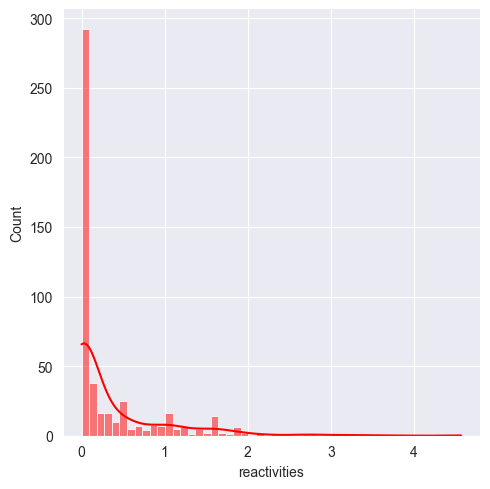

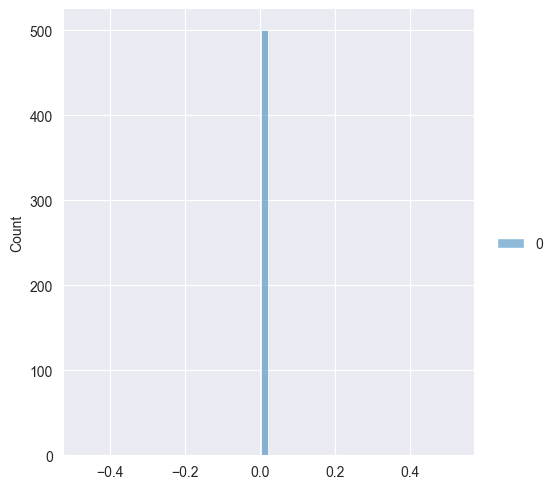

In [30]:
g_density = sns.displot(data=y_test[:500], kde=True, color='RED', bins=50)
g_prediction_density = sns.displot(data=predictions[:500], kde=True, color='RED', bins=50)

In [ ]:
'''# Model building                                         Current best solo regression model for DMS
model_2A3 = tf.keras.Sequential([  
    tf.keras.layers.Conv1D(8, 1, activation='linear', batch_input_shape = (32, 1644, 1),padding='same'),
    tf.keras.layers.Conv1D(16, 1, activation='linear',padding='same'),
    tf.keras.layers.Conv1D(32, 1, activation='linear',padding='same'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dense(1)]
)'''

In [ ]:
'''# Model building                                    Current best solo regression model for 2A3
model_2A3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(8, 1, activation='linear', batch_input_shape = (32, 1644, 1),padding='same'),
    tf.keras.layers.Conv1D(16, 1, activation='linear',padding='same'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    #tf.keras.layers.Conv1D(32, 1, activation='linear',padding='same'),
    #tf.keras.layers.Conv1D(64, 1, activation='linear',padding='same'),
    #tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)]
)'''

### Building a Submission
This part should have been easy, but the 'small sample' of sequences we need to test in './test_sequences.csv' is huge.
This entire process needs to be optimized. (and major code clean up on my behalf)

In [ ]:
base_dict = {   'A': [1,0,0,0],
                'C': [0,1,0,0],
                'G': [0,0,1,0],
                'U': [0,0,0,1] }
def test_base(sequence, pos):
    test_b = []
    for n in range(-205,206):
        if 0 <= (n + pos) < len(sequence):
            test_b+=base_dict[sequence[pos+n]]
        else:
            test_b+=[0,0,0,1]
    return test_b

# entry builder (for the feature dictionary method; inefficient, and will likely be replaced after converting preprocess pipeline)
def append_base(b, pos):
    if pos < 0:
        sign = 'n'
    else:
        sign = ''
    end = sign + str(abs(pos))
    if b == 'A':
        feat_dict['b_A_' + end].append(1)
        feat_dict['b_C_' + end].append(0)
        feat_dict['b_G_' + end].append(0)
        feat_dict['b_U_' + end].append(0)
    elif b == 'C':
        feat_dict['b_A_' + end].append(0)
        feat_dict['b_C_' + end].append(1)
        feat_dict['b_G_' + end].append(0)
        feat_dict['b_U_' + end].append(0)
    elif b == 'G':
        feat_dict['b_A_' + end].append(0)
        feat_dict['b_C_' + end].append(0)
        feat_dict['b_G_' + end].append(1)
        feat_dict['b_U_' + end].append(0)
    elif b == 'U':
        feat_dict['b_A_' + end].append(0)
        feat_dict['b_C_' + end].append(0)
        feat_dict['b_G_' + end].append(0)
        feat_dict['b_U_' + end].append(1)
    else:
        feat_dict['b_A_' + end].append(0)
        feat_dict['b_C_' + end].append(0)
        feat_dict['b_G_' + end].append(0)
        feat_dict['b_U_' + end].append(0)

# submission builder
test_set = pd.read_csv('input/test_sequences.csv')

line = "id,reactivity_DMS_MaP,reactivity_2A3_MaP"
sub_file = open("submission.csv", "w")
sub_file.write(line)
sub_file.close()

b_id = -1
feat_dict = dict()
for index, row in test_set.iterrows():
    seq = row['sequence']
    sub_file = open("submission.csv", "a")
    for i in range(len(seq)):
        b_id+=1
        for x in features:
            feat_dict[x] = []
        for n in range(-205,206):
            if 0 <= (n + i) < len(seq):
                append_base(seq[i+n], n)
            else:
                append_base(0, n)
        single_entry_df = pd.DataFrame(feat_dict)
        react_DMS = model_DMS.predict(single_entry_df)
        react_2A3 = model_2A3.predict(single_entry_df)
        line = "\n" + str(b_id) + "," + str(react_DMS[0][0]) + "," + str(react_2A3[0][0])
        sub_file.write(line)
    sub_file.close()   
    print(f"Bases finished: {b_id}")

In [ ]:
#todo; design a much faster submission builder than this one...
# resume submission builder
test_set = pd.read_csv('./input/test_sequences.csv')

start_id = '' #determine starting id
start_id = int(list(open("submission.csv",errors='ignore'))[-1].split(",")[0])+1
print(f"Starting at base id: {start_id}")

b_id = -1
test_bases = []
for index, row in test_set.iterrows():
    seq = row['sequence']
    for i in range(len(seq)):
        b_id+=1
        if b_id >= start_id:
            test_bases+= [tuple(test_base(seq, i))]
            if ((b_id+1)-start_id) % 100000 == 0:   # process every 100000 bases
                rDMS, r2A3 = model_DMS.predict(np.array(test_bases)), model_2A3.predict(np.array(test_bases))
                sub_file = open("submission.csv", "a")
                for i in range(len(rDMS)):
                    sub_file.write("\n" + str(start_id) + "," + str(rDMS[i][0]) + "," + str(r2A3[i][0]))
                    start_id+=1
                sub_file.close()
                test_bases = []
                print(f"Bases finished: {b_id}")
        
if test_bases:
        rDMS, r2A3 = model_DMS.predict(np.array(test_bases)), model_2A3.predict(np.array(test_bases))
        sub_file = open("submission.csv", "a")
        for i in range(len(rDMS)):
            sub_file.write("\n" + str(start_id) + "," + str(rDMS[i][0]) + "," + str(r2A3[i][0]))
            start_id+=1
        sub_file.close()
        test_bases = []

In [ ]:
#submission builder speed test
test_set = pd.read_csv('./input/test_sequences.csv')

line = "id,reactivity_DMS_MaP,reactivity_2A3_MaP"
sub_file = open("sub_speed_test.csv", "w")
sub_file.write(line)
sub_file.close()

start = time.time()
start_id = 0
b_id = -1
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    test_bases = []
    for index, row in test_set.iterrows():
        seq = row['sequence']
        for i in range(len(seq)):
            b_id+=1
            print(f"new bid: {b_id}")
            test_bases+= [tuple(test_base(seq, i))]
            if b_id >= 100000:
                break
        if ((b_id+1)-start_id) % 100000 == 0 or b_id >= 100000:
            rDMS, r2A3 = model_DMS.predict(np.array(test_bases)), model_2A3.predict(np.array(test_bases))
            sub_file = open("sub_speed_test.csv", "a")
            for i in range(len(rDMS)):
                sub_file.write("\n" + str(start_id) + "," + str(rDMS[i][0]) + "," + str(r2A3[i][0]))
                start_id+=1
            sub_file.close()
            test_bases = []
            if b_id >= 100000:
                break

end = time.time()
elapsed = end - start

line = "\nTime elapsed for 100000 bases: " + str(elapsed)  + " seconds."
sub_file = open("sub_speed_test.csv", "a")
sub_file.write(line)
sub_file.close()
print(line)

In [ ]:
# progress check
final_id = 269796670 # the final b_id in test_sequences.csv
last_id = '' # determine last id written by model
for line in list(open("submission.csv", errors="ignore"))[-1]:
    last_id += line
last_id = int(last_id.split(",")[0])

print(f"Submission Completion:\n{last_id}/{final_id}\t{100*last_id/final_id:.2f}%")

In [ ]:
test = pd.read_csv('submission.csv', errors='ignore')
test.head()